In [1]:
import os

import pickle
import re
import arviz as az
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import pymc as pm

basepath = '/Users/hwunrow/Documents/GitHub/rt-estimation/data/'
dirs = os.listdir(basepath)
search_dirs = [dir for dir in dirs if '2023-01-26' in dir]

In [11]:
import importlib
import model
importlib.reload(model)

<module 'model' from '/Users/hwunrow/Documents/GitHub/rt-estimation/src/model.py'>

In [12]:
with open(f"{basepath}/2023-02-05_NUTS_likelihood_normal_add_noise_in_mcmc_clip_before_noise/model.pkl", 'rb') as file:
        sir_model = pickle.load(file)

In [16]:
import inspect
lines = inspect.getsource(sir_model)
print(lines)

import pymc as pm
import pytensor.tensor as pt
from pytensor import scan

import logging
import os
from pprint import pformat

import numpy as np
import pandas as pd

import arviz as az
from matplotlib.backends.backend_pdf import PdfPages

import pickle
import cloudpickle


class SIR_model():

    def __init__(self, data):
        self.data = data
        self.setup_SIR_model()

    def setup_SIR_model(self):
        self.I0 = pm.floatX(self.data.I[0])
        self.S0 = pm.floatX(self.data.N - self.I0)
        self.i = self.data.i[1:]
        self.n_t = self.data.n_t

    def run_SIR_model(
      self, n_samples, n_tune, likelihood, prior, method, path
      ):
        self.likelihood = likelihood
        self.n_samples = n_samples
        self.n_tune = n_tune
        self.likelihood = likelihood
        self.prior = prior
        self.method = method

        if not os.path.exists(path):
            os.makedirs(path)

        logging.basicConfig(
            filename=f'{path}/example.

In [5]:
vars = ['rt_0', 'rt_1', 'k', 'midpoint', 'I0']

array([[<AxesSubplot: title={'center': 'rt_0'}>,
        <AxesSubplot: title={'center': 'rt_0'}>],
       [<AxesSubplot: title={'center': 'rt_1'}>,
        <AxesSubplot: title={'center': 'rt_1'}>],
       [<AxesSubplot: title={'center': 'k'}>,
        <AxesSubplot: title={'center': 'k'}>],
       [<AxesSubplot: title={'center': 'midpoint'}>,
        <AxesSubplot: title={'center': 'midpoint'}>],
       [<AxesSubplot: title={'center': 'I0'}>,
        <AxesSubplot: title={'center': 'I0'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

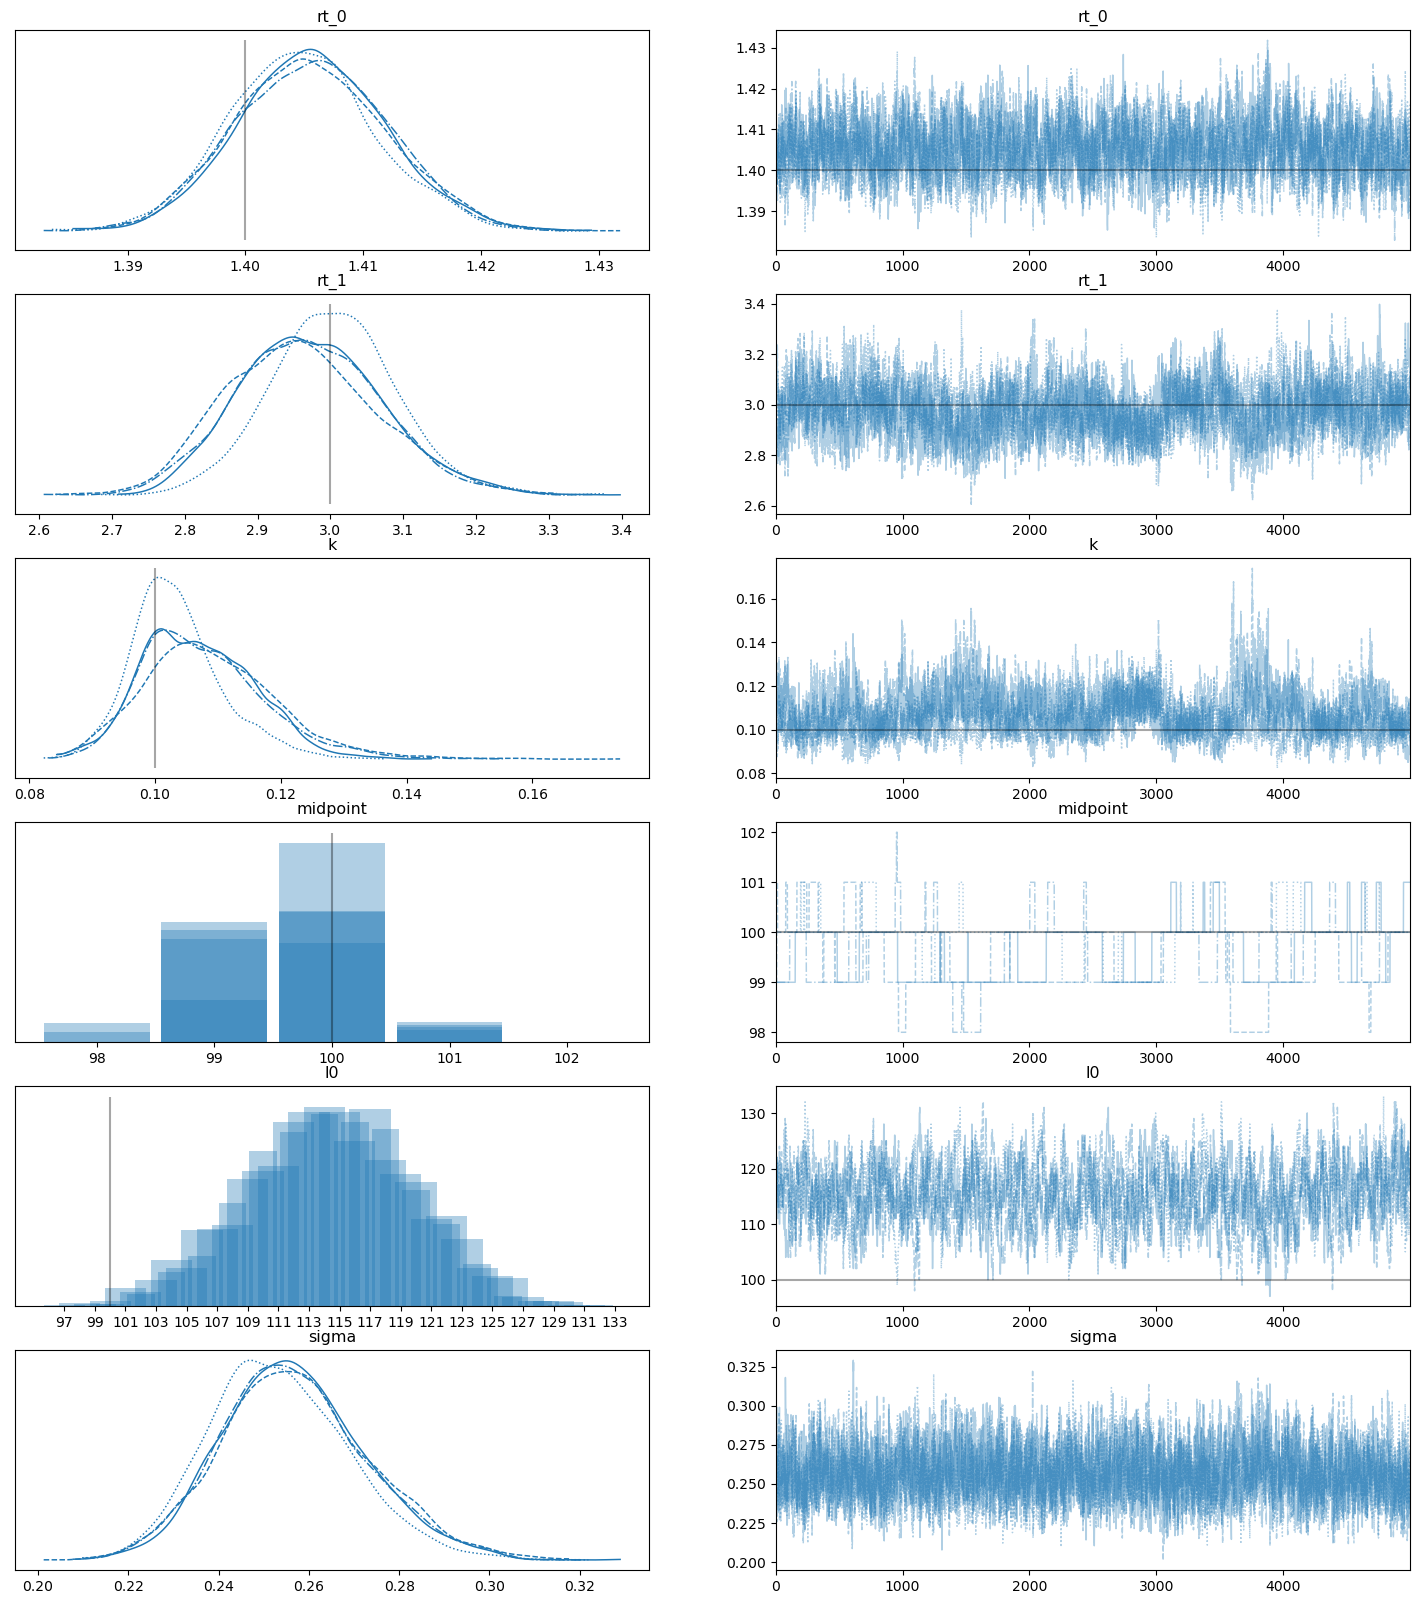

In [6]:
lines = [(var, {}, getattr(sir_model.data, var)) for var in vars]
az.plot_trace(sir_model.trace, var_names=vars+['sigma'], lines=lines, figsize=(18, 20))

array([[<AxesSubplot: title={'center': 'rt_0'}>,
        <AxesSubplot: title={'center': 'rt_1'}>,
        <AxesSubplot: title={'center': 'k'}>],
       [<AxesSubplot: title={'center': 'midpoint'}>,
        <AxesSubplot: title={'center': 'I0'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

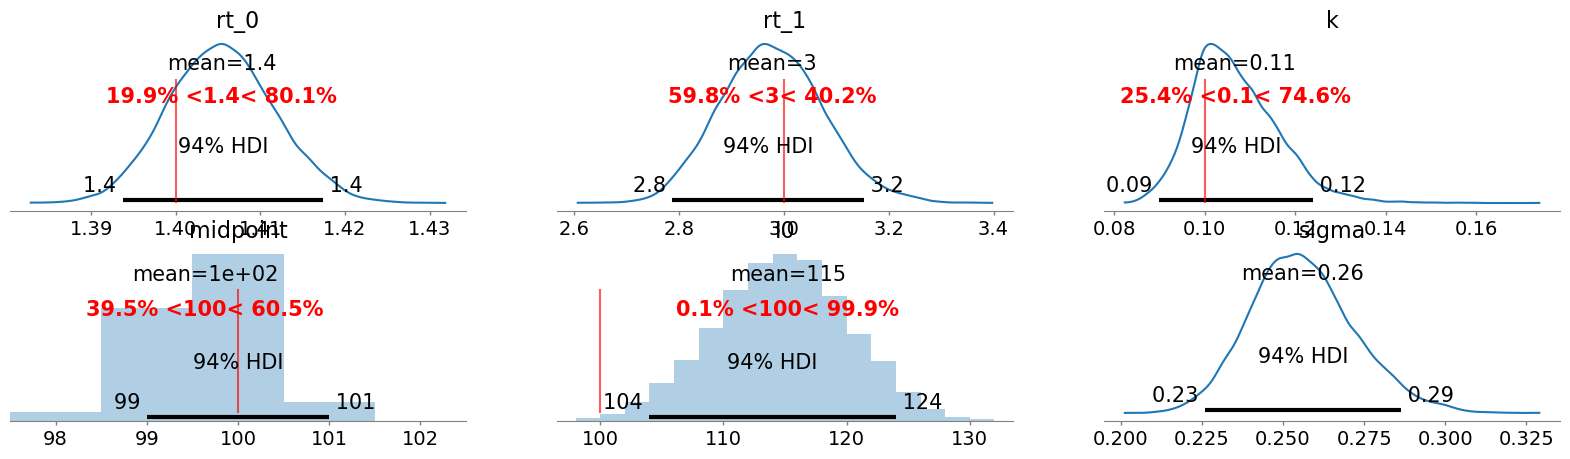

In [9]:
ref_val = {var: [{"ref_val": getattr(sir_model.data, var)}] for var in vars}
az.plot_posterior(
            sir_model.trace,
            var_names=vars+['sigma'],
            ref_val=ref_val,
            ref_val_color='red',
            figsize=(20, 5),
            )

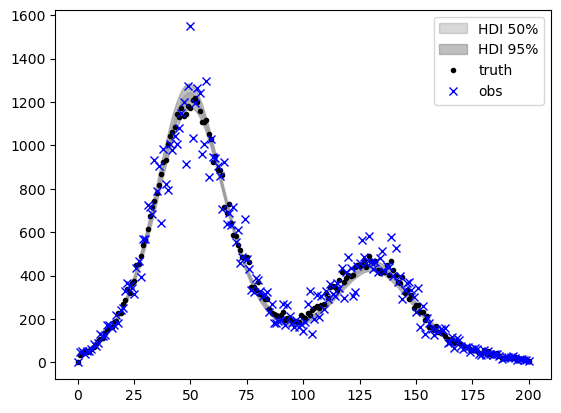

In [35]:
fig, ax = plt.subplots()

az.plot_hdi(
    x=range(200),
    y=sir_model.trace.posterior["i"],
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax
)
az.plot_hdi(
    x=range(200),
    y=sir_model.trace.posterior["i"],
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax
)
ax.plot(sir_model.data.i_true, '.', label="truth", color='black')
ax.plot(sir_model.data.i, 'x', label="obs", color='blue')

ax.legend()


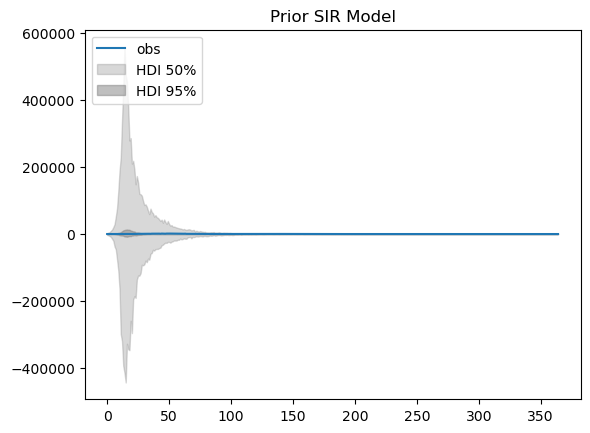

In [12]:
fig, ax = plt.subplots()

t = np.arange(365)

ax.plot(t, sir_model.data.i[1:], color="C0", label="obs")

az.plot_hdi(
    x=t,
    y=sir_model.trace.prior_predictive["i_est"],
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=t,
    y=sir_model.trace.prior_predictive["i_est"],
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Prior SIR Model");

In [15]:
sir_model.posterior_predictive

Inference data with groups:
	> posterior_predictive
	> observed_data

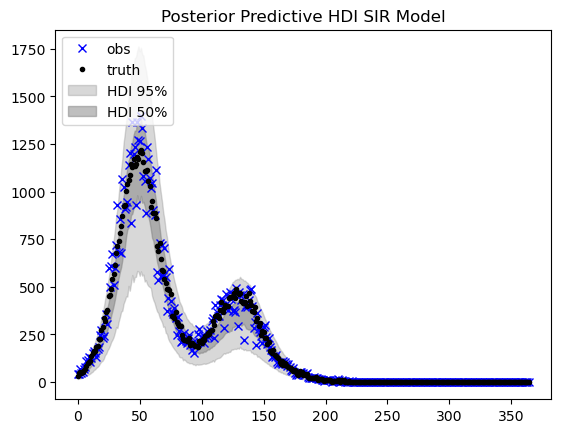

In [10]:
fig, ax = plt.subplots()

t = np.arange(365)

ax.plot(t, sir_model.data.i[1:], 'x', color="blue", label="obs")
ax.plot(t, sir_model.data.i_true[1:], '.', label="truth", color='black')

az.plot_hdi(
    x=t,
    y=sir_model.posterior_predictive.posterior_predictive["i_est"],
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=t,
    y=sir_model.posterior_predictive.posterior_predictive["i_est"],
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Posterior Predictive HDI SIR Model");

In [17]:
ci_95 = az.hdi(
            sir_model.posterior_predictive.posterior_predictive,
            var_names=["i_est"], hdi_prob=0.95).i_est.values
ci_50 = az.hdi(
    sir_model.posterior_predictive.posterior_predictive,
    var_names=["i_est"], hdi_prob=0.50).i_est.values
prop_95 = np.mean((ci_95[:, 0] <= sir_model.i) & (sir_model.i <= ci_95[:, 1]))
prop_50 = np.mean((ci_50[:, 0] <= sir_model.i) & (sir_model.i <= ci_50[:, 1]))
print(f"Percent of observations in 95% CI {round(prop_95*100, 2)}%")
print(f"Percent of observations in 50% CI {round(prop_50*100, 2)}%")

Percent of observations in 95% CI 96.99%
Percent of observations in 50% CI 59.73%


In [35]:
az.hdi(sir_model.trace.posterior, var_names=["k"], hdi_prob=0.95)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    k        (hdi) float64 0.08971 0.1256

In [36]:
az.hdi(sir_model.trace.posterior, var_names=["k"], hdi_prob=0.99)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    k        (hdi) float64 0.08604 0.1351

In [37]:
ci_95 = az.hdi(sir_model.posterior_predictive.posterior_predictive, var_names=["i_est"], hdi_prob = 0.95).i_est.values
ci_50 = az.hdi(sir_model.posterior_predictive.posterior_predictive, var_names=["i_est"], hdi_prob = 0.50).i_est.values

In [48]:
np.mean((ci_50[:,0] <= sir_model.i) & (sir_model.i <= ci_50[:,1]))

0.5972602739726027

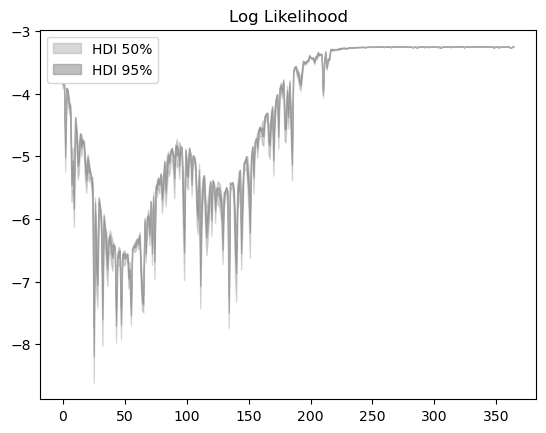

In [17]:
fig, ax = plt.subplots()

t = np.arange(365)

az.plot_hdi(
    x=t,
    y=sir_model.trace.log_likelihood["i_est"],
    hdi_prob=0.95,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 50%", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=t,
    y=sir_model.trace.log_likelihood["i_est"],
    hdi_prob=0.5,
    color="gray",
    smooth=False,
    fill_kwargs={"label": "HDI 95%", "alpha": 0.5},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Log Likelihood");

In [29]:
sir_model.trace.posterior['i'].mean(dim=["chain"])

pm.StudentT("i_est",
            nu=sir_model.likelihood['nu'],
            mu=i,
            sigma=pt.abs(1+sir_model.likelihood['sigma']*i))

<xarray.DataArray 'i' (draw: 5000, i_dim_0: 365)>
array([[3.38117484e+01, 3.74440879e+01, 4.14606866e+01, ...,
        4.43783639e-05, 4.12006976e-05, 3.82505959e-05],
       [3.39637982e+01, 3.76029032e+01, 4.16259546e+01, ...,
        5.62489128e-05, 5.22841692e-05, 4.85989722e-05],
       [3.40921068e+01, 3.77585852e+01, 4.18132599e+01, ...,
        4.09232074e-05, 3.79839556e-05, 3.52558506e-05],
       ...,
       [3.52246740e+01, 3.89065971e+01, 4.29670223e+01, ...,
        4.86093929e-05, 4.51594937e-05, 4.19545601e-05],
       [3.51305575e+01, 3.88008323e+01, 4.28482646e+01, ...,
        5.63866049e-05, 5.24101725e-05, 4.87142210e-05],
       [3.47175956e+01, 3.83558258e+01, 4.23691934e+01, ...,
        7.40959388e-05, 6.89669245e-05, 6.41931697e-05]])
Coordinates:
  * draw     (draw) int32 0 1 2 3 4 5 6 7 ... 4993 4994 4995 4996 4997 4998 4999
  * i_dim_0  (i_dim_0) int32 0 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363 364

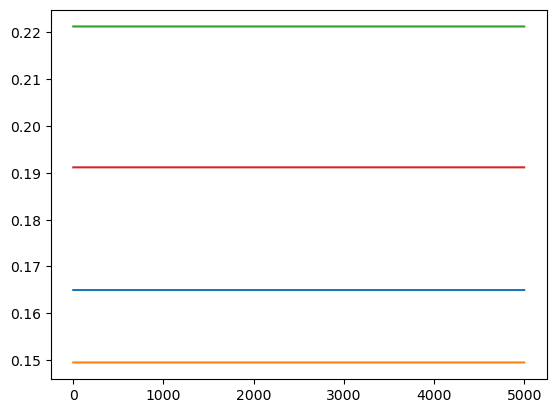

In [20]:
import matplotlib.pyplot as plt

plt.plot(sir_model.trace.sample_stats['step_size'].values.T)

In [3]:
df_list = []
for search_dir in search_dirs:
    print(search_dir)
    with open(f'{basepath}/{search_dir}/model.pkl', 'rb') as file:
        sir_model = pickle.load(file)

    vars = re.findall(r'\[\'.*?\'\]', search_dir)[0][2:-2].split("\', \'")
    
    hdi = az.hdi(sir_model.trace, var_names=vars, hdi_prob = 0.95).to_dataframe()
    
    data = {}
    for var in vars:
        true_var = getattr(sir_model.data, var)
        # print(var)
        # print(hdi[var]['lower'])
        # print(hdi[var]['higher'])
        # print(f"In HDI? {(hdi[var]['lower'] <= true_var) & (true_var <= hdi[var]['higher'])}")
        data = data | {
            f'{var}_lower': [hdi[var]['lower']],
            f'{var}_higher': [hdi[var]['higher']],
            f'{var}_true': [true_var]
        }
    df = pd.DataFrame.from_dict(data)
    df['directory'] = search_dir
    df['inferred parameters'] = str(vars)
    df['num inferred parameters'] = len(vars)
    df_list.append(df)

2023-01-26_metropolis_infer_['k', 'I0']
2023-01-26_metropolis_infer_['k', 'midpoint', 'I0']
2023-01-26_metropolis_infer_['midpoint', 'I0']
2023-01-26_metropolis_infer_['rt_0', 'I0']
2023-01-26_metropolis_infer_['rt_0', 'k', 'I0']
2023-01-26_metropolis_infer_['rt_0', 'k', 'midpoint', 'I0']
2023-01-26_metropolis_infer_['rt_0', 'midpoint', 'I0']
2023-01-26_metropolis_infer_['rt_0', 'rt_1', 'I0']
2023-01-26_metropolis_infer_['rt_0', 'rt_1', 'k', 'I0']
2023-01-26_metropolis_infer_['rt_0', 'rt_1', 'k', 'midpoint', 'I0']
2023-01-26_metropolis_infer_['rt_0', 'rt_1', 'midpoint', 'I0']
2023-01-26_metropolis_infer_['rt_1', 'I0']
2023-01-26_metropolis_infer_['rt_1', 'k', 'I0']
2023-01-26_metropolis_infer_['rt_1', 'k', 'midpoint', 'I0']
2023-01-26_metropolis_infer_['rt_1', 'midpoint', 'I0']
2023-01-26_NUTS_infer_['rt_0', 'rt_1', 'k', 'midpoint', 'I0']


In [4]:
df_hdi = pd.concat(df_list)

In [5]:
df_hdi

,k_lower,k_higher,k_true,I0_lower,I0_higher,I0_true,directory,inferred parameters,num inferred parameters,midpoint_lower,midpoint_higher,midpoint_true,rt_0_lower,rt_0_higher,rt_0_true,rt_1_lower,rt_1_higher,rt_1_true
0,0.101233,0.110519,0.1,111.0,121.0,100.0,"2023-01-26_metropolis_infer_['k', 'I0']","['k', 'I0']",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.101330,0.111140,0.1,110.0,123.0,100.0,"2023-01-26_metropolis_infer_['k', 'midpoint', ...","['k', 'midpoint', 'I0']",3,99.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,111.0,127.0,100.0,"2023-01-26_metropolis_infer_['midpoint', 'I0']","['midpoint', 'I0']",2,99.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,107.0,122.0,100.0,"2023-01-26_metropolis_infer_['rt_0', 'I0']","['rt_0', 'I0']",2,NaN,NaN,NaN,1.396564,1.405636,1.4,NaN,NaN,NaN
0,0.106750,0.123347,0.1,93.0,111.0,100.0,"2023-01-26_metropolis_infer_['rt_0', 'k', 'I0']","['rt_0', 'k', 'I0']",3,NaN,NaN,NaN,1.404902,1.418824,1.4,NaN,NaN,NaN
0,0.112057,0.130845,0.1,91.0,109.0,100.0,"2023-01-26_metropolis_infer_['rt_0', 'k', 'mid...","['rt_0', 'k', 'midpoint', 'I0']",4,98.0,99.0,100.0,1.415628,1.432684,1.4,NaN,NaN,NaN
0,NaN,NaN,NaN,107.0,122.0,100.0,"2023-01-26_metropolis_infer_['rt_0', 'midpoint...","['rt_0', 'midpoint', 'I0']",3,98.0,100.0,100.0,1.399960,1.413333,1.4,NaN,NaN,NaN
0,NaN,NaN,NaN,91.0,109.0,100.0,"2023-01-26_metropolis_infer_['rt_0', 'rt_1', '...","['rt_0', 'rt_1', 'I0']",3,NaN,NaN,NaN,1.415834,1.439434,1.4,3.137347,3.340593,3.0
0,0.093877,0.116070,0.1,91.0,109.0,100.0,"2023-01-26_metropolis_infer_['rt_0', 'rt_1', '...","['rt_0', 'rt_1', 'k', 'I0']",4,NaN,NaN,NaN,1.411193,1.437428,1.4,3.000786,3.342470,3.0
0,0.111737,0.177178,0.1,93.0,113.0,100.0,"2023-01-26_metropolis_infer_['rt_0', 'rt_1', '...","['rt_0', 'rt_1', 'k', 'midpoint', 'I0']",5,97.0,99.0,100.0,1.401501,1.433406,1.4,2.676072,3.087919,3.0


In [6]:
# df_hdi.to_csv(f'{basepath}/hdi_summary.csv', index=False)

In [14]:
beta_true = sir_model.data.rt / sir_model.data.t_I

In [32]:
beta_hat = sir_model.trace.posterior["beta_t"].mean(dim=["chain", "draw"]).data
beta_ci = az.hdi(sir_model.trace, var_names="beta_t", hdi_prob=0.95).to_array().squeeze().data

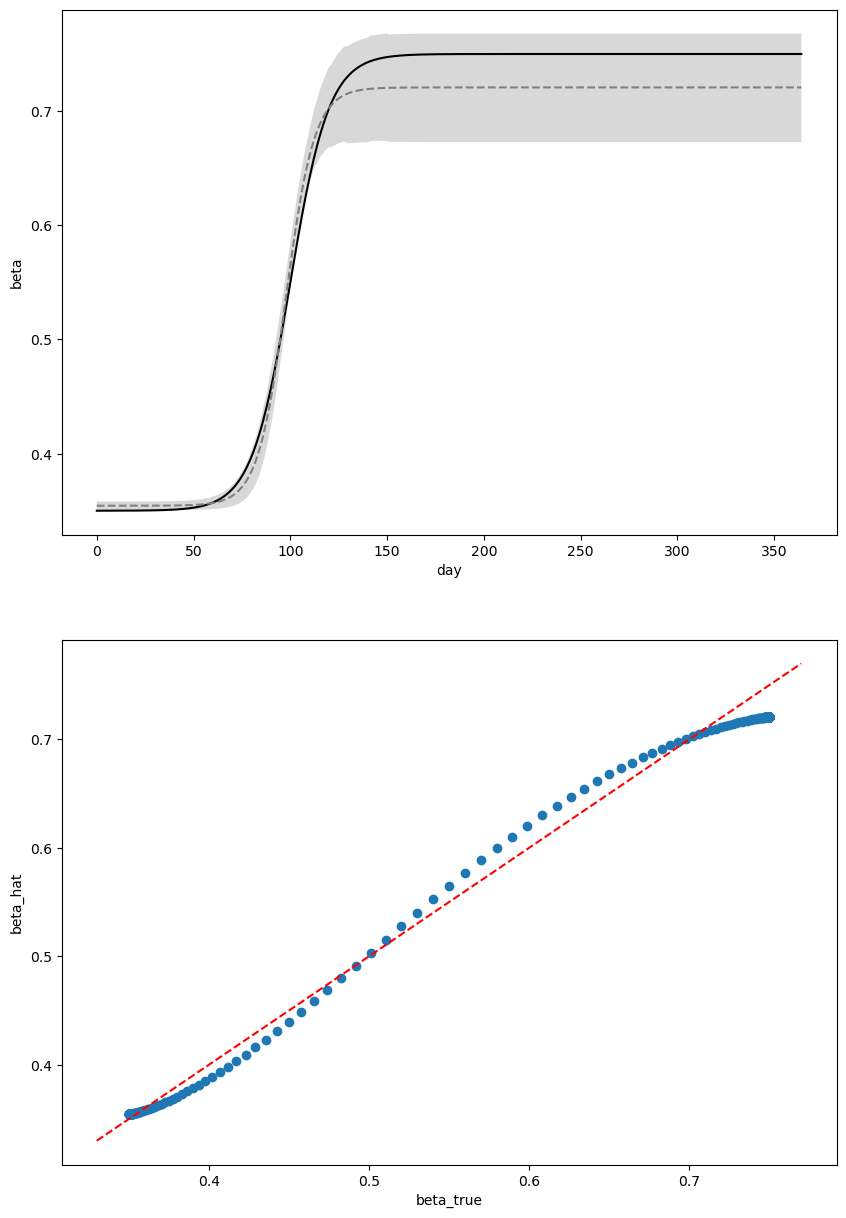

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, figsize=(10, 15))

t = np.arange(365)

ax[0].plot(t, beta_true, color="black", label="truth")
ax[0].plot(t, beta_hat, '--', color="gray", label="posterior mean")
ax[0].fill_between(t, beta_ci[:, 0], beta_ci[:, 1], facecolor='gray', alpha=0.3, label='95% HDI')
ax[0].set_xlabel('day')
ax[0].set_ylabel('beta')

ax[1].scatter(beta_true, beta_hat)
ax[1].set_xlabel('beta_true')
ax[1].set_ylabel('beta_hat')
x_vals = np.array(ax[1].get_xlim())
y_vals = x_vals
plt.plot(x_vals, y_vals, '--', color='red')

In [44]:
sir_model.data.I0
sir_model.data.S0
sir_model.data.N

100000.0

In [53]:
from scipy.integrate import odeint
from scipy.interpolate import interp1d

def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta_true_interp(t) * S * I / N
    dIdt = beta_true_interp(t) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
S0_true = sir_model.data.S0
I0_true = sir_model.data.I0
N = sir_model.data.N
R0_true = N - S0_true - I0_true
y0 = S0_true, I0_true, R0_true

# ODE parameters
gamma_true = 1./sir_model.data.t_I
beta_true_interp = interp1d(t, beta_true, bounds_error=False, fill_value="extrapolate")

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta_true_interp, gamma_true))
S, I, R = ret.T

In [63]:
# Initial conditions vector
S0_true = sir_model.data.S0
I0_hat = sir_model.trace.posterior["I0"].mean().values
N = sir_model.data.N
R0_hat = N - S0_true - I0_hat
y0_hat = S0_true, I0_hat, R0_hat

# ODE parameters
gamma_true = 1./sir_model.data.t_I
beta_hat_interp = interp1d(t, beta_hat, bounds_error=False, fill_value="extrapolate")

# Integrate the SIR equations over the time grid, t.
ret_hat = odeint(deriv, y0_hat, t, args=(N, beta_hat_interp, gamma_true))
S_hat, I_hat, R_hat = ret_hat.T

In [74]:
S_post = sir_model.trace.posterior["S"].mean(dim=["draw", "chain"]).values
I_post = sir_model.trace.posterior["I"].mean(dim=["draw", "chain"]).values
R_post = N - S_post - I_post

In [76]:
len(S_post)

365

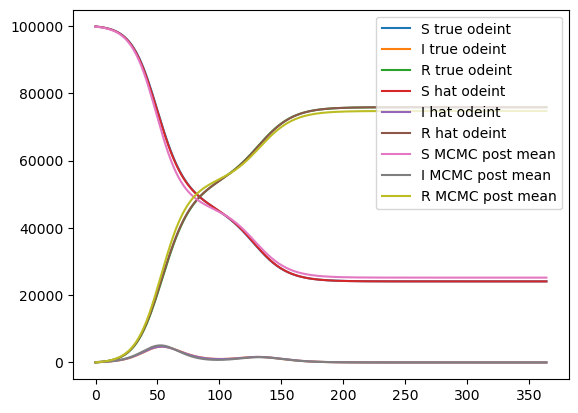

In [79]:
plt.plot(S, label="S true odeint")
plt.plot(I, label="I true odeint")
plt.plot(R, label="R true odeint")
plt.plot(S_hat, label="S hat odeint")
plt.plot(I_hat, label="I hat odeint")
plt.plot(R_hat, label="R hat odeint")
plt.plot(S_post, label="S MCMC post mean")
plt.plot(I_post, label="I MCMC post mean")
plt.plot(R_post, label="R MCMC post mean")
plt.legend()

In [81]:
I_post[0]

113.97232684725446

In [80]:
I_hat[0]

103.23855